## Setup

Install all the Python libraries below. They should all be pretty easy to install with something like pip install

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Importing multiple plates with different layouts

Make a subfolder called "growth data" and put your files in there. Before I work with the plate files, I open the plate file in a text editor and do the follow three things:
- Remove all the stuff before the list of column headers (So until "Time   T600    A1    A2" etc)
- Remove all the stuff after the last measurement (Remove all the "00.00.00" and everything afterwards
- Remove the weird character in the temperature heading (I think it's an infinity sign?)

The code below will take the plate data and do most of the useful transformations you need for you. It can handle multiple plate files with different (or identical) layouts. The way the "files" list variable works for defining the plate layout is:
- Each sublist is a plate with data
- The first item is the file name
- The second item is the name of media conditions (or whatever condition you like) per column. They can be identical for multiple columns
- The third and fourth items define groups, which are used in the fifth item. I did in a bit of a hacky way, but here's how it works. "MG1655": [1, 0] means: from the rows (A,B, ..) pick the first group of rows. In this case, ABCD. For the columns (1, 2, ...), pick the first group of columns. In this case, all of them.
- The reason I did it this way is to make it fast to define your plate layout. I set the fifth item to be genotype, but in principle, you could have any variable there (concentration, whatever).
- We made it this way because our experiment had usually two axes of variation (genotype and media). You can use any two axes of variation you like.

In [55]:
files = [   

            # orig
            ["growth_data/cyrus_blue_020824.txt",
              {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "Zn", "H": "B12"},
              [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
              [["A", "B", "C", "D"], ["E", "F", "G", "H"]],
              {"YkgM1": [0, 0], "MG1655": [1, 0]},
             12],

            # # good?
             ["growth_data/cyrus_pink_020924.txt",
             {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             [["A", "B", "C", "D", "E", "F", "G"]],
             {"MG1655": [0, 0]},
              12],
             
    
        ]




for i, file in enumerate(files):

    fname = file[0]
    additive = file[1]
    genotype_col = file[2]
    genotype_row = file[3]
    genotype_combinations = file[4]
    n_replicate = file[5]

    al = pl.DataFrame(additive).transpose(include_header=True)
    al = al.rename({"column": "Row", "column_0": "Additive"})
    al = al.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    gl = []
    
    for genotype, idx in genotype_combinations.items():
    
        gl.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

    gl = pl.DataFrame(gl).transpose()
    gl = gl.rename({"column_0": "Genotype", "column_1": "Well"})
    gl = gl.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    if i == 0:    
        df = pl.read_csv(fname, separator="\t") # growth_data/cyrus_mutant_013124.txt
        df = df.with_columns(Plate = pl.lit("Plate 1"))
        df = df.with_columns(N_replicate = n_replicate)
        df = df.drop('T600')

        gdf = gl
        adf = al

    else:
        df_add = pl.read_csv(fname, separator="\t")
        df_add = df_add.with_columns(Plate = pl.lit(f"Plate {i+1}"))
        df_add = df_add.with_columns(N_replicate = n_replicate)
        df_add = df_add.drop('T600')
        df = pl.concat([df, df_add])

        gdf = pl.concat([gdf, gl])
        adf = pl.concat([adf, al])

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# get minimum OD measured, used to be 1.5
init_df = df.filter(pl.col("Time") > 1).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

init_df_median = df.filter(pl.col("Time") < 5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD_median")
init_df_median = init_df_median.group_by(["Plate", "Well"]).median()

init_df

# blank_df.head(3)
df.head(3)

shape: (3, 99)
┌──────────┬───────┬───────┬───────┬───┬───────┬──────┬─────────┬─────────────┐
│ Time     ┆ A1    ┆ A2    ┆ A3    ┆ … ┆ H11   ┆ H12  ┆ Plate   ┆ N_replicate │
│ ---      ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---     ┆ ---         │
│ f64      ┆ f64   ┆ f64   ┆ f64   ┆   ┆ f64   ┆ f64  ┆ str     ┆ i32         │
╞══════════╪═══════╪═══════╪═══════╪═══╪═══════╪══════╪═════════╪═════════════╡
│ 0.011111 ┆ 0.096 ┆ 0.094 ┆ 0.096 ┆ … ┆ 0.11  ┆ 0.09 ┆ Plate 1 ┆ 12          │
│ 0.036111 ┆ 0.096 ┆ 0.094 ┆ 0.096 ┆ … ┆ 0.11  ┆ 0.09 ┆ Plate 1 ┆ 12          │
│ 0.061111 ┆ 0.096 ┆ 0.094 ┆ 0.096 ┆ … ┆ 0.111 ┆ 0.09 ┆ Plate 1 ┆ 12          │
└──────────┴───────┴───────┴───────┴───┴───────┴──────┴─────────┴─────────────┘

In [3]:
# melt to experiments
mdf = df.melt(id_vars=["Time", "Plate", "N_replicate"], variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

mdf = mdf.join(adf, on=["Plate", "Row"])
mdf = mdf.join(gdf, on=["Plate", "Well"])
mdf = mdf.join(init_df, on=["Well", "Plate"])
mdf = mdf.join(init_df_median, on=["Well", "Plate"])

mdf = mdf.with_columns(   ((pl.col("Column").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))

# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+11) % 12 + 1).alias("Replicate"))
# mdf.group_by(["Plate","Additive","Genotype"]).size()
# mdf = mdf.filter(pl.col("Genotype") == "MG1655")

mdf.head()

shape: (5, 12)
┌──────────┬─────────┬─────────────┬──────┬───┬──────────┬────────────┬────────────────┬───────────┐
│ Time     ┆ Plate   ┆ N_replicate ┆ Well ┆ … ┆ Genotype ┆ Initial_OD ┆ Initial_OD_med ┆ Replicate │
│ ---      ┆ ---     ┆ ---         ┆ ---  ┆   ┆ ---      ┆ ---        ┆ ian            ┆ ---       │
│ f64      ┆ str     ┆ i32         ┆ str  ┆   ┆ str      ┆ f64        ┆ ---            ┆ i32       │
│          ┆         ┆             ┆      ┆   ┆          ┆            ┆ f64            ┆           │
╞══════════╪═════════╪═════════════╪══════╪═══╪══════════╪════════════╪════════════════╪═══════════╡
│ 0.011111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ YkgM1    ┆ 0.096      ┆ 0.097          ┆ 1         │
│ 0.036111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ YkgM1    ┆ 0.096      ┆ 0.097          ┆ 1         │
│ 0.061111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ YkgM1    ┆ 0.096      ┆ 0.097          ┆ 1         │
│ 0.086111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ YkgM1    ┆ 0.096      ┆ 0.097          ┆ 1         │
│ 0.111111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ YkgM1    ┆ 0.096      ┆ 0.097          ┆ 1         │
└──────────┴─────────┴─────────────┴──────┴───┴──────────┴────────────┴────────────────┴───────────┘

## Correcting initial OD

Here we subtract the estimated "base OD" from the measured OD over time. Since we are adding a 10000x dilution of cells, we assume that their contribution to the initial OD is very neglible, so we can just use a starting measurement. However, the initial hour or so sometimes has weird stuff happening, so I usually pick the minimum value found after the first hour has passed.

In [4]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
])

mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD_median")).alias("Initial_median_corrected_OD"), 
])


mdf.head(5)

shape: (5, 14)
┌──────────┬─────────┬─────────────┬──────┬───┬─────────────┬───────────┬─────────────┬────────────┐
│ Time     ┆ Plate   ┆ N_replicate ┆ Well ┆ … ┆ Initial_OD_ ┆ Replicate ┆ Initial_cor ┆ Initial_me │
│ ---      ┆ ---     ┆ ---         ┆ ---  ┆   ┆ median      ┆ ---       ┆ rected_OD   ┆ dian_corre │
│ f64      ┆ str     ┆ i32         ┆ str  ┆   ┆ ---         ┆ i32       ┆ ---         ┆ cted_OD    │
│          ┆         ┆             ┆      ┆   ┆ f64         ┆           ┆ f64         ┆ ---        │
│          ┆         ┆             ┆      ┆   ┆             ┆           ┆             ┆ f64        │
╞══════════╪═════════╪═════════════╪══════╪═══╪═════════════╪═══════════╪═════════════╪════════════╡
│ 0.011111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.097       ┆ 1         ┆ 0.0         ┆ -0.001     │
│ 0.036111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.097       ┆ 1         ┆ 0.0         ┆ -0.001     │
│ 0.061111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.097       ┆ 1         ┆ 0.0         ┆ -0.001     │
│ 0.086111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.097       ┆ 1         ┆ 0.0         ┆ -0.001     │
│ 0.111111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ 0.097       ┆ 1         ┆ 0.0         ┆ -0.001     │
└──────────┴─────────┴─────────────┴──────┴───┴─────────────┴───────────┴─────────────┴────────────┘

(0.0, 1.0)

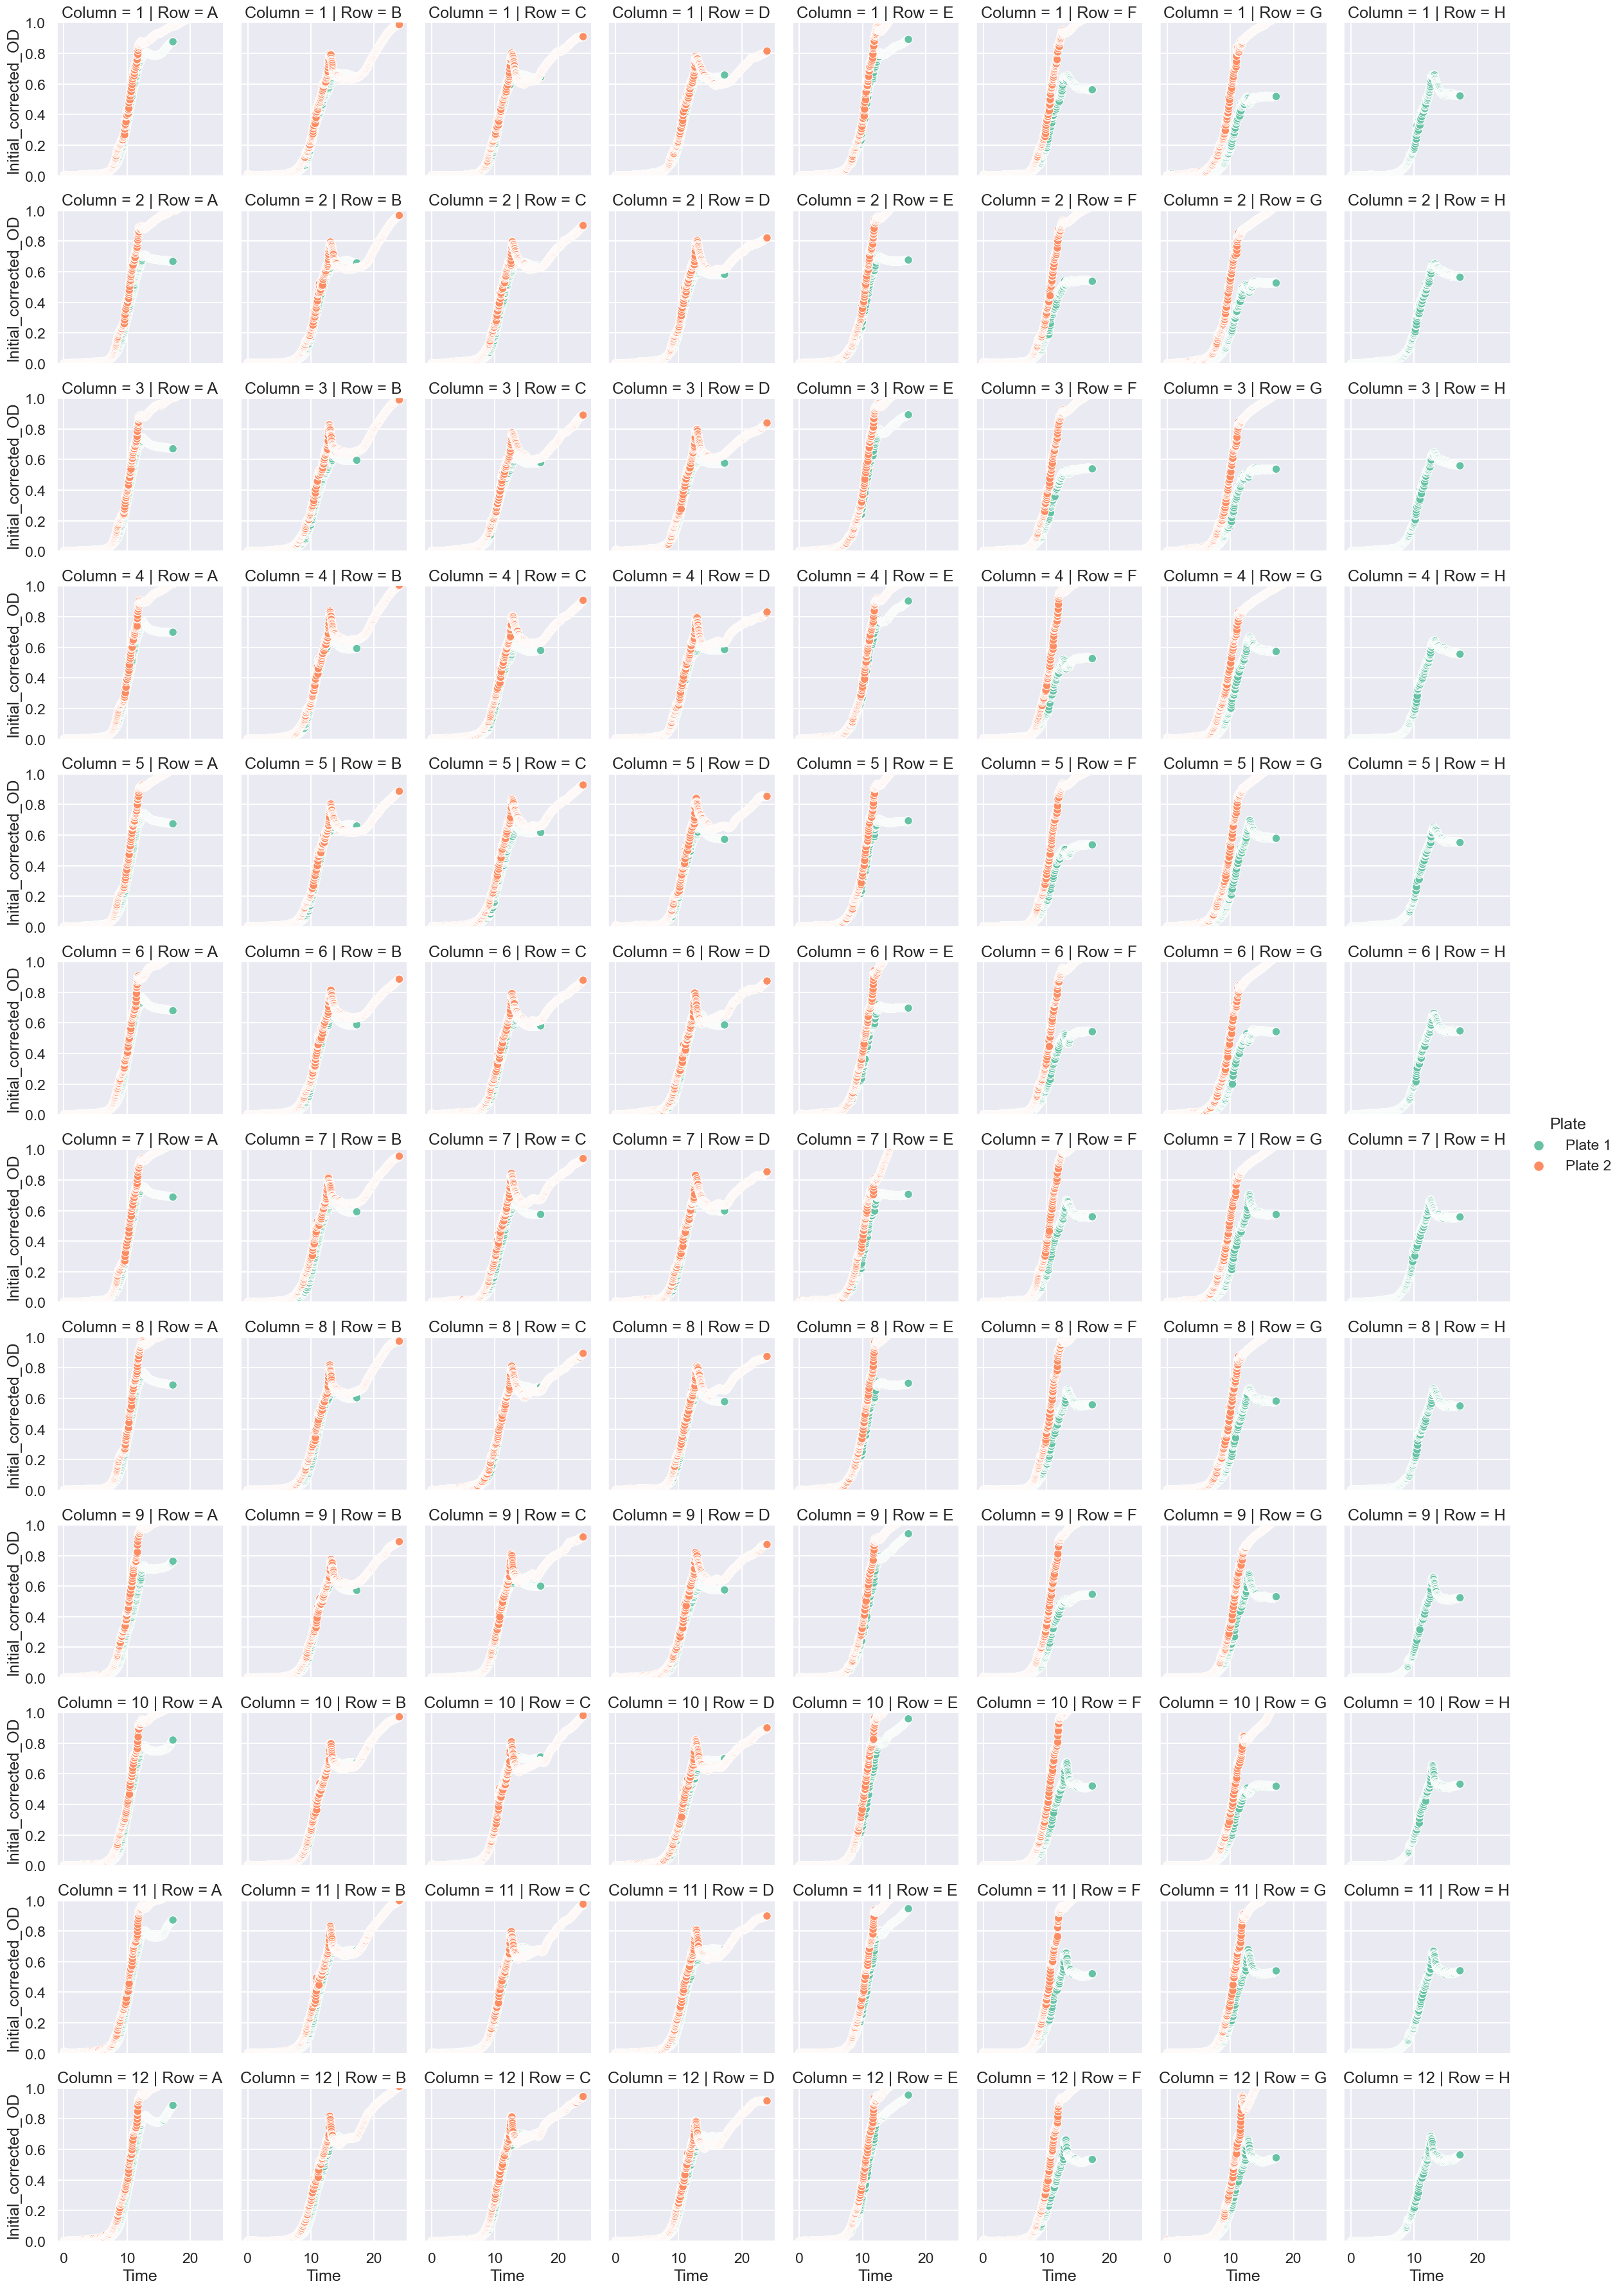

In [5]:
sns.set_context("talk")

sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", col="Row", row="Column", \
            # row="Genotype", 
            height=3, \
            # col_wrap=4,
            data=mdf)

plt.ylim(0,1)

## Log-transforming data

Despite people in papers often showing the raw OD measurements, they're actually very misleading, since most of the true exponential growth stops around OD 0.1-0.2 in a 96-well plate, where ODs usually hit around 1. After OD 0.2, the cells are no longer growing at a constant exponential rate!!!!!!!!

This was a big surprise to me.

I made an example plot below showing 4 wells, and how the OD and Log OD don't really convey the same picture at all. Most of the exponential growth happens when the raw OD is barely moving! The plate reader is actually quite sensitive at very low OD changes of ~0.001 OD. 

In [54]:
f_mdf = mdf.filter(pl.col("Time") > 1).filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_corrected_OD")).log())
    .alias("Log_initial_corrected_OD")
])

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_median_corrected_OD")).log())
    .alias("Log_initial_median_corrected_OD")
])


f_mdf = f_mdf.filter(pl.col("Log_initial_corrected_OD").is_not_nan())

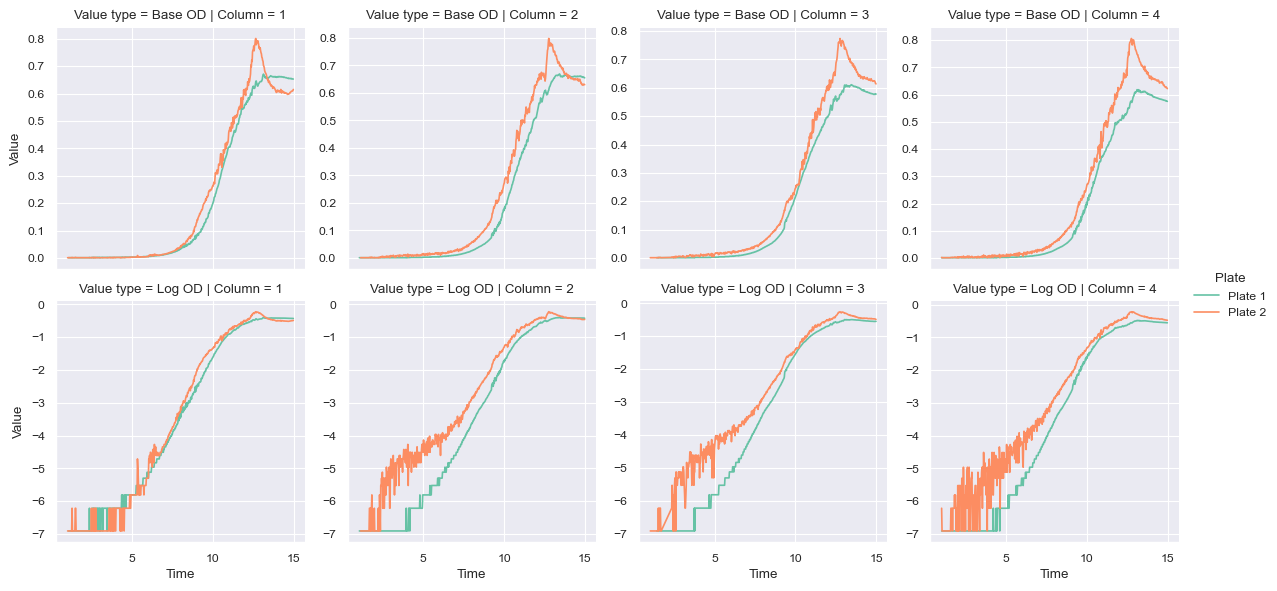

In [53]:
showcase_df = f_mdf.filter((pl.col("Row") == "C")) \
.filter(pl.col("Column").is_in([str(i) for i in range(1,5)])) \
.rename({"Initial_corrected_OD": "Base OD", "Log_initial_corrected_OD": "Log OD"}) \
.select(["Time", "Column", "Plate", "Base OD", "Log OD"]) \
.melt(id_vars=["Time", "Column", "Plate"], variable_name="Value type", value_name="Value")


showcase_df.head()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Value", hue="Plate", kind="line", row="Value type", col="Column", height=3, \
                data=showcase_df.filter(pl.col("Time") < 15), facet_kws={"sharey": False})


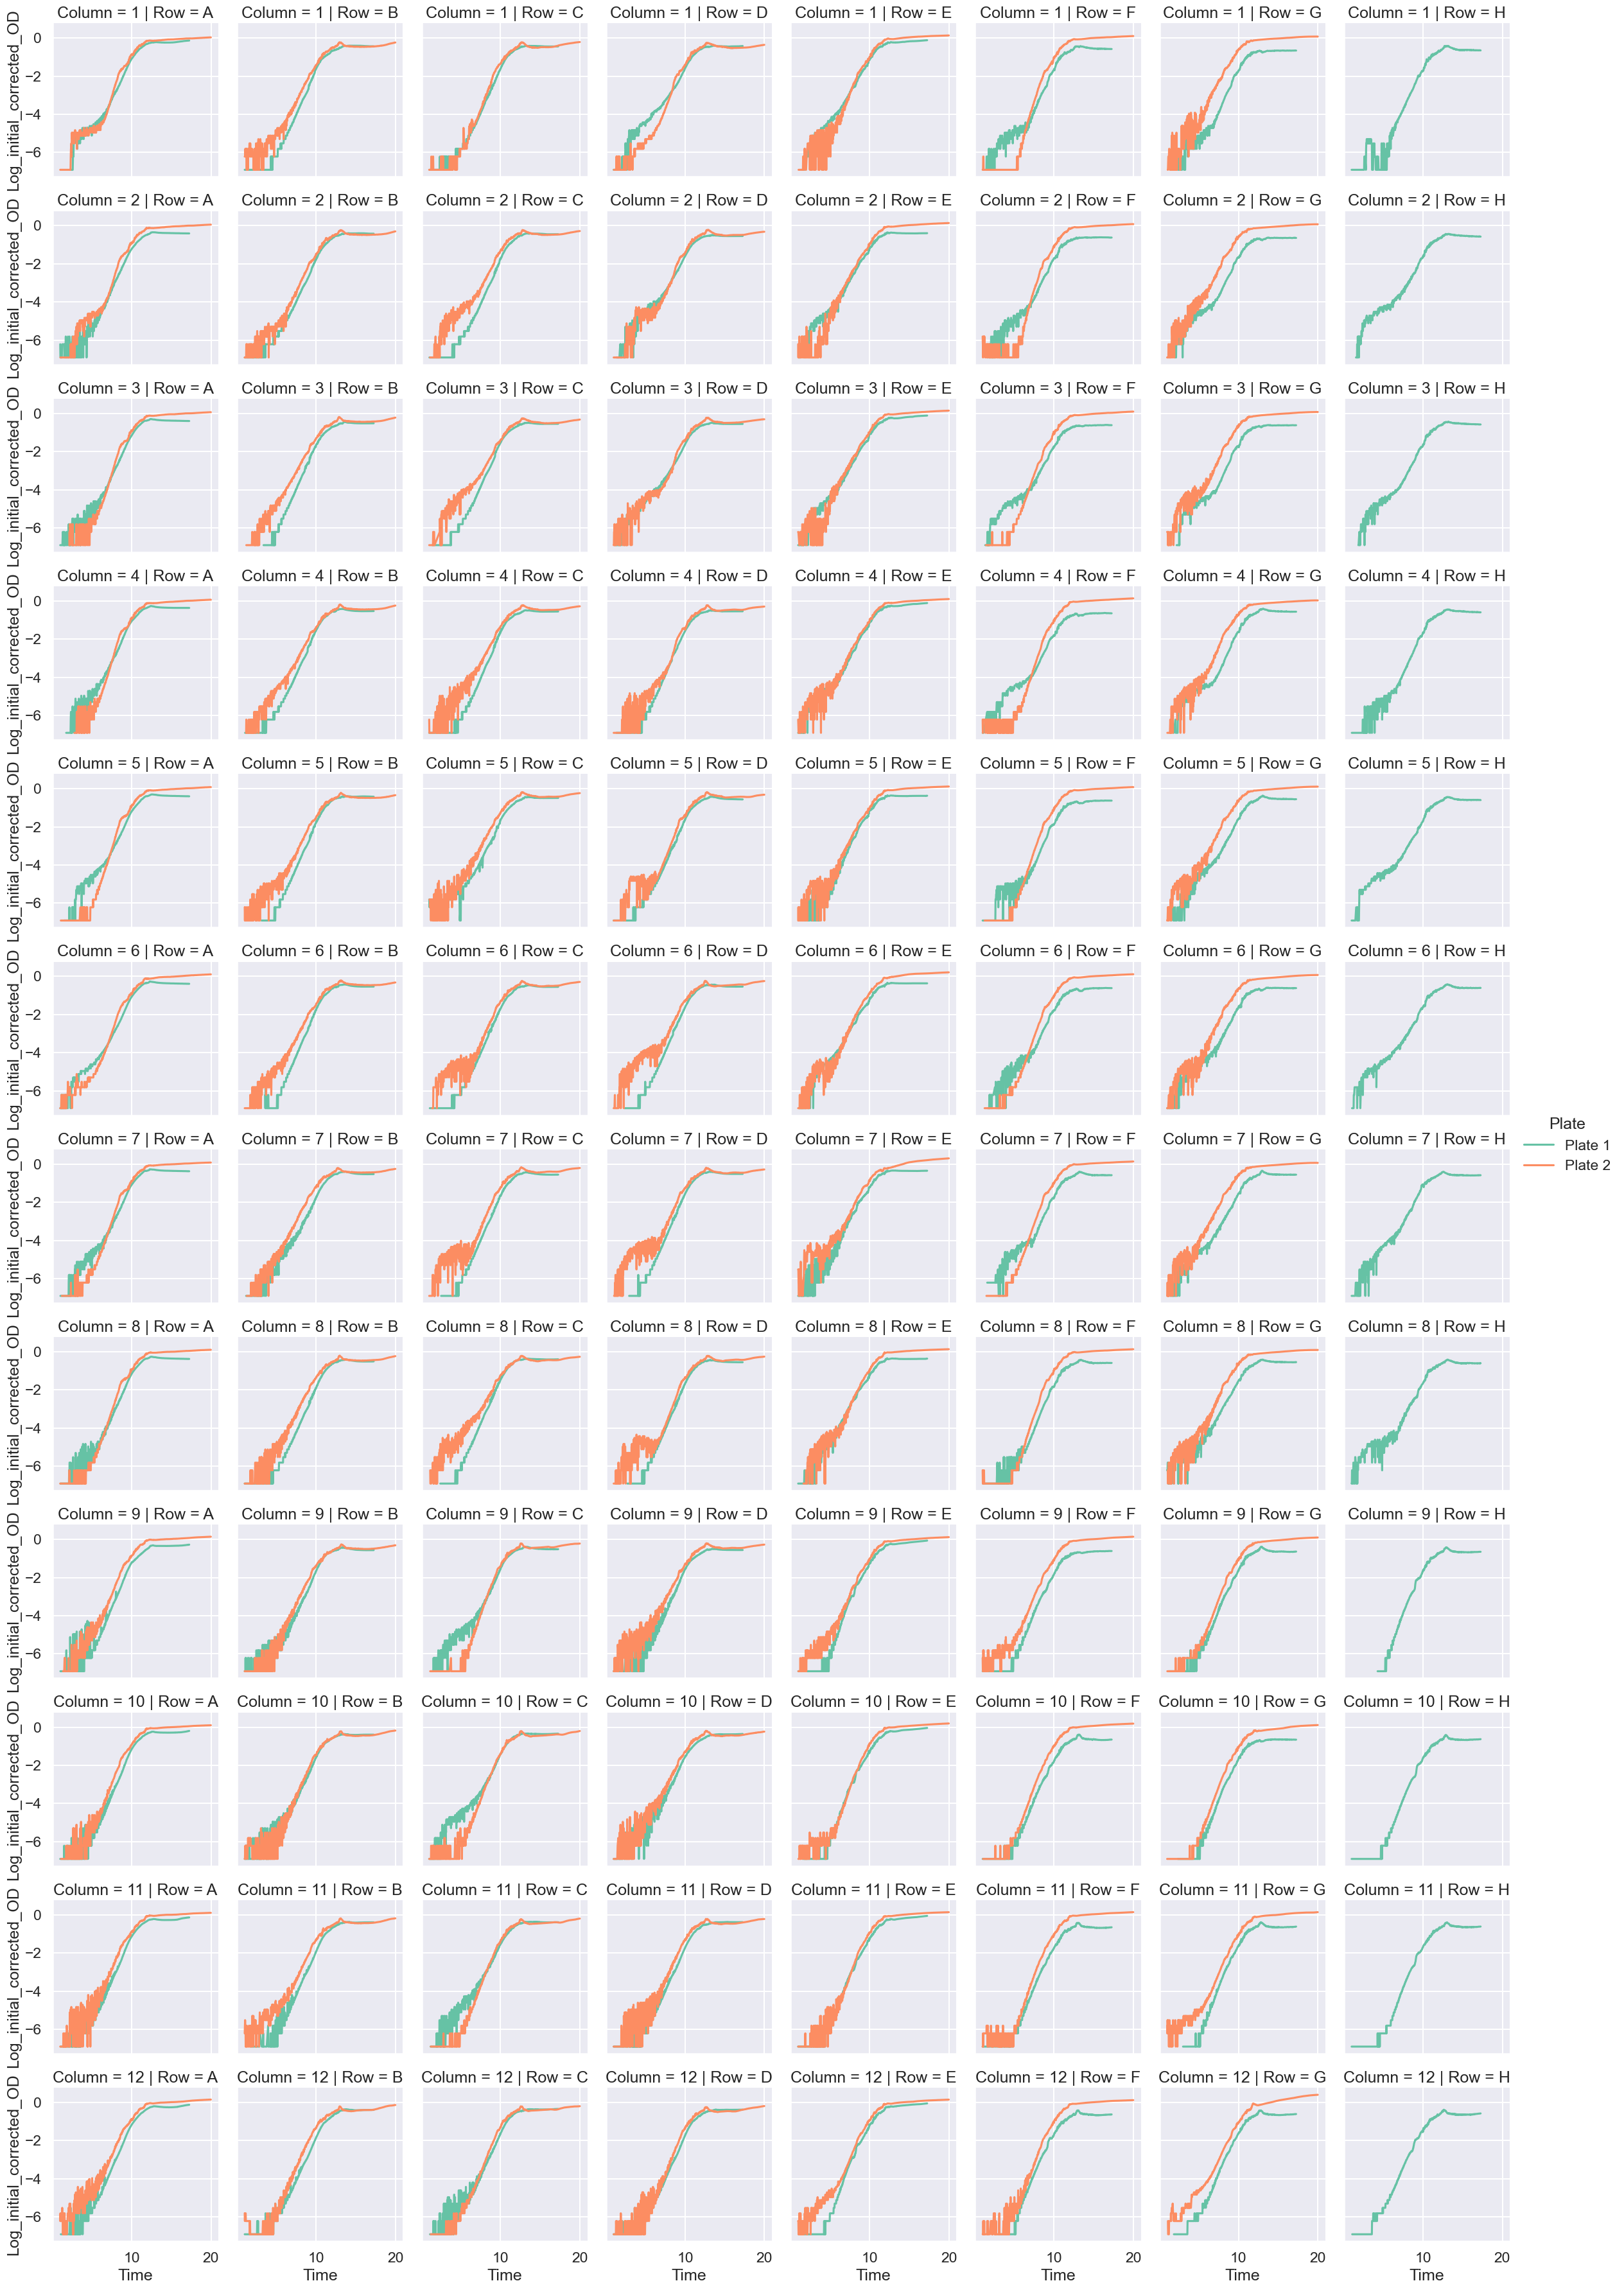

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Column", col="Row", height=3, \
                data=f_mdf.filter(pl.col("Time") < 20))


## Extract linear region

In order to estimate the growth rate, I extract the region of the curve that's linear on a log-OD scale. This is not a black and white question, sometimes it can be a bit difficult to exactly pinpoint it. 

Usually I try to have the range span at least 1 logOD (e.g. -4 to -3), ideally more. Empirically, I find that the -4 to -2 region is most accurate. I usually am able to include from -5.5 to -2, if the data allows it depending on noise. 

In [8]:
# place your filter limits here based on the curves
lower = -4.
upper = -3.


gr_df = f_mdf
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= lower).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= upper).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)



shape: (5, 19)
┌──────────┬─────────┬─────────────┬──────┬───┬─────────────┬────────────┬────────────┬────────────┐
│ Time     ┆ Plate   ┆ N_replicate ┆ Well ┆ … ┆ Log_initial ┆ Time_exp_s ┆ Time_exp_e ┆ Corrected_ │
│ ---      ┆ ---     ┆ ---         ┆ ---  ┆   ┆ _median_cor ┆ tart       ┆ nd         ┆ time       │
│ f64      ┆ str     ┆ i32         ┆ str  ┆   ┆ rected_OD   ┆ ---        ┆ ---        ┆ ---        │
│          ┆         ┆             ┆      ┆   ┆ ---         ┆ f64        ┆ f64        ┆ f64        │
│          ┆         ┆             ┆      ┆   ┆ f64         ┆            ┆            ┆            │
╞══════════╪═════════╪═════════════╪══════╪═══╪═════════════╪════════════╪════════════╪════════════╡
│ 6.661111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ -3.963316   ┆ 6.636111   ┆ 7.736111   ┆ 0.025      │
│ 6.686111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ -4.017384   ┆ 6.636111   ┆ 7.736111   ┆ 0.05       │
│ 6.711111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ -3.963316   ┆ 6.636111   ┆ 7.736111   ┆ 0.075      │
│ 6.736111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ -3.912023   ┆ 6.636111   ┆ 7.736111   ┆ 0.1        │
│ 6.761111 ┆ Plate 1 ┆ 12          ┆ A1   ┆ … ┆ -4.017384   ┆ 6.636111   ┆ 7.736111   ┆ 0.125      │
└──────────┴─────────┴─────────────┴──────┴───┴─────────────┴────────────┴────────────┴────────────┘

## Pick out top growth rates

For my specific experiment, we are interested in estimating the maximum growth rate. Individual wells seem to more often than not be slightly messed up, due to either the plate reader, media evaporation, salts forming, or inoculation incidents. 

To counter this, I usually just pick the top N replicates per condition. This usually fixes it, since these problems rarely result in faster-than-normal apparent growth rates.

In [9]:
# M is the lower bound (e.g. top 1), N is the upper bound 
# (e.g. the Mth fastest growth rate to the Nth fastest growth rate)
M = 0
N = 3

# regress and pick top x 
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()

top_gr = pl.DataFrame(predicted_gr.sort_values(by=["Genotype", "Additive", "Plate", "slope"], ascending=False).groupby(['Genotype', 'Additive', 'Plate']).nth[M:N])
top_gr.head(7)

gr_df = gr_df.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"])

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_2231/2873715172.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()


Plot the filtered replicates together, first all the data then the linear region.

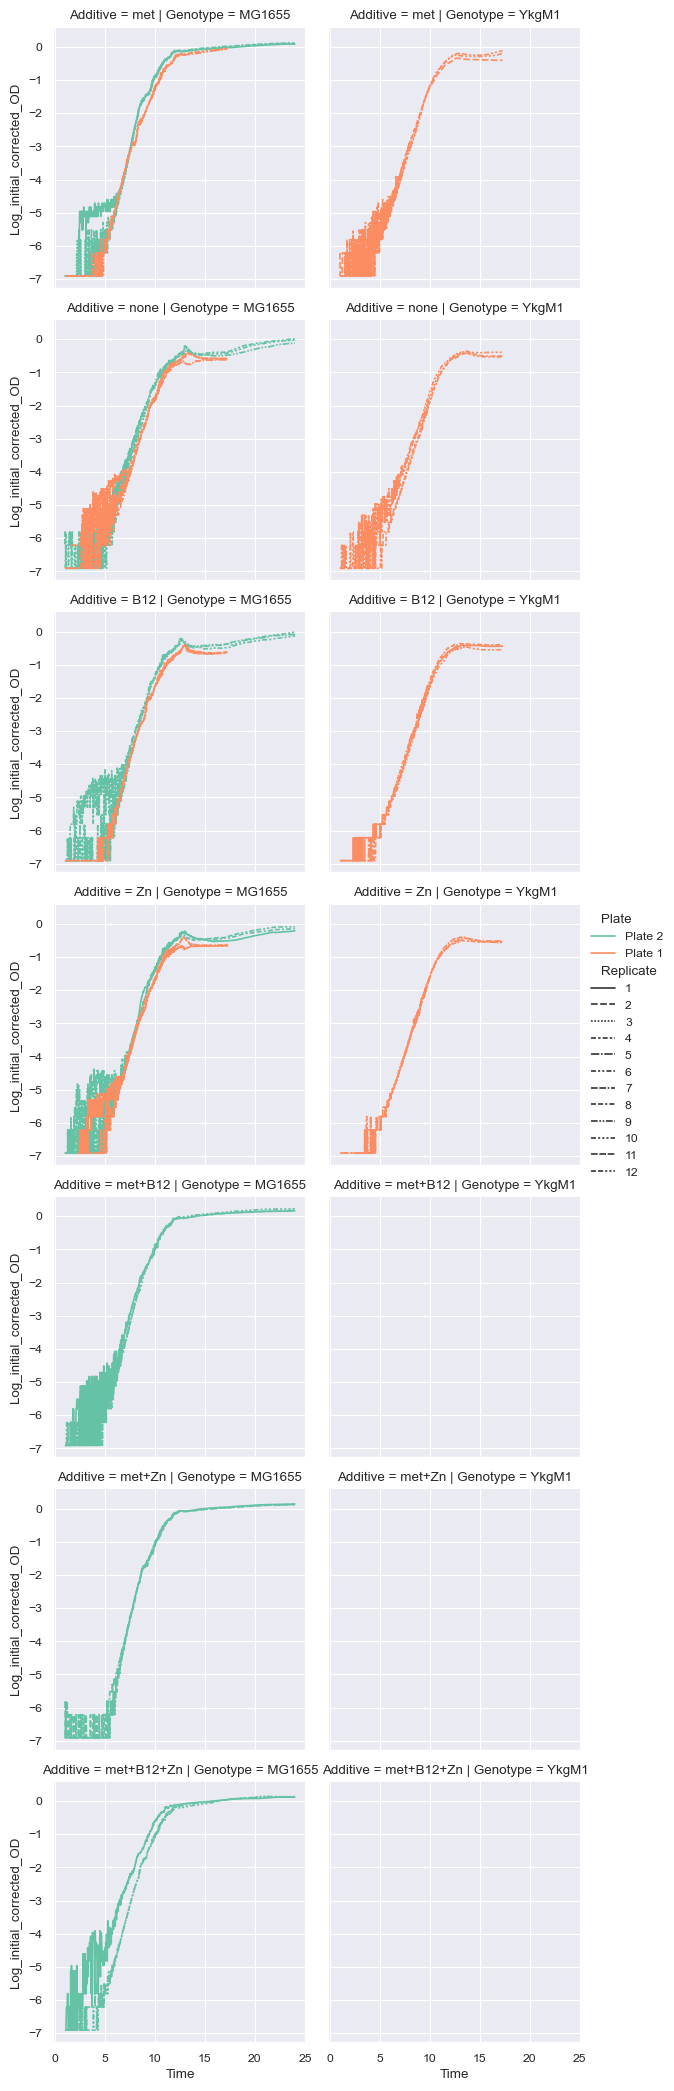

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Genotype", row="Additive", style="Replicate", height=3, \
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]))

# plt.savefig("weird_plate.png")

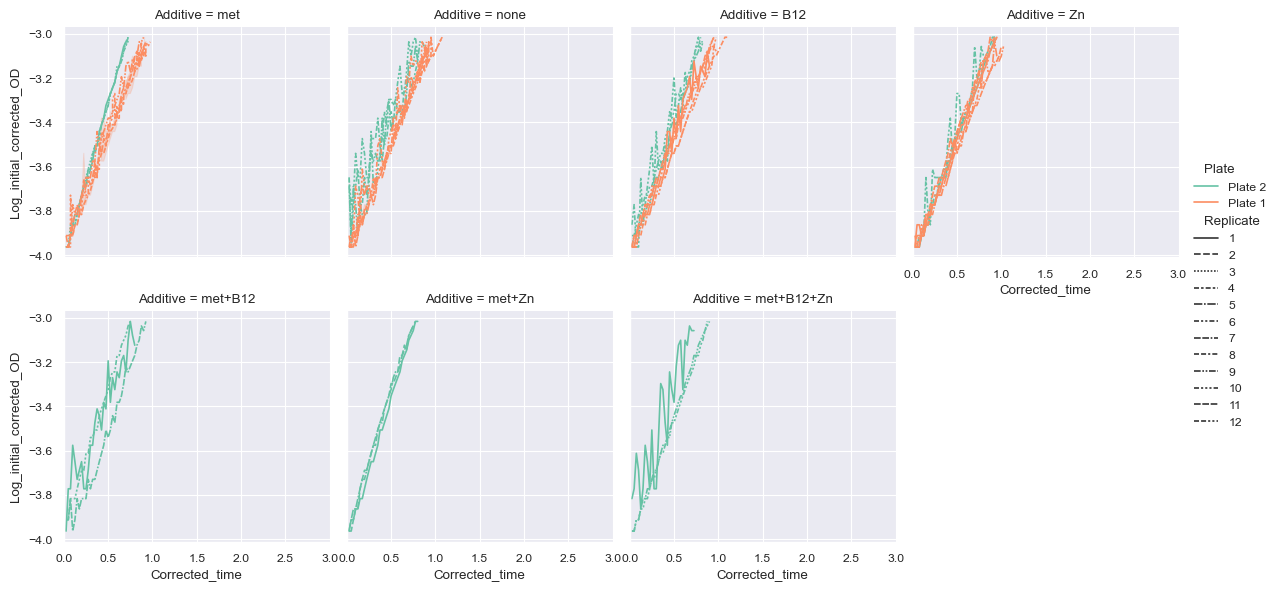

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_context("paper")
    sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                col_wrap=4, 
                # row="Genotype",
                height=3, \
                data=gr_df)
    
    plt.xlim([0,3])

# plt.savefig("plates.png")

Construct linear model plots for each condition. These linear models should be similar to the ones seen in the bar plot below.

(0.0, 3.0)

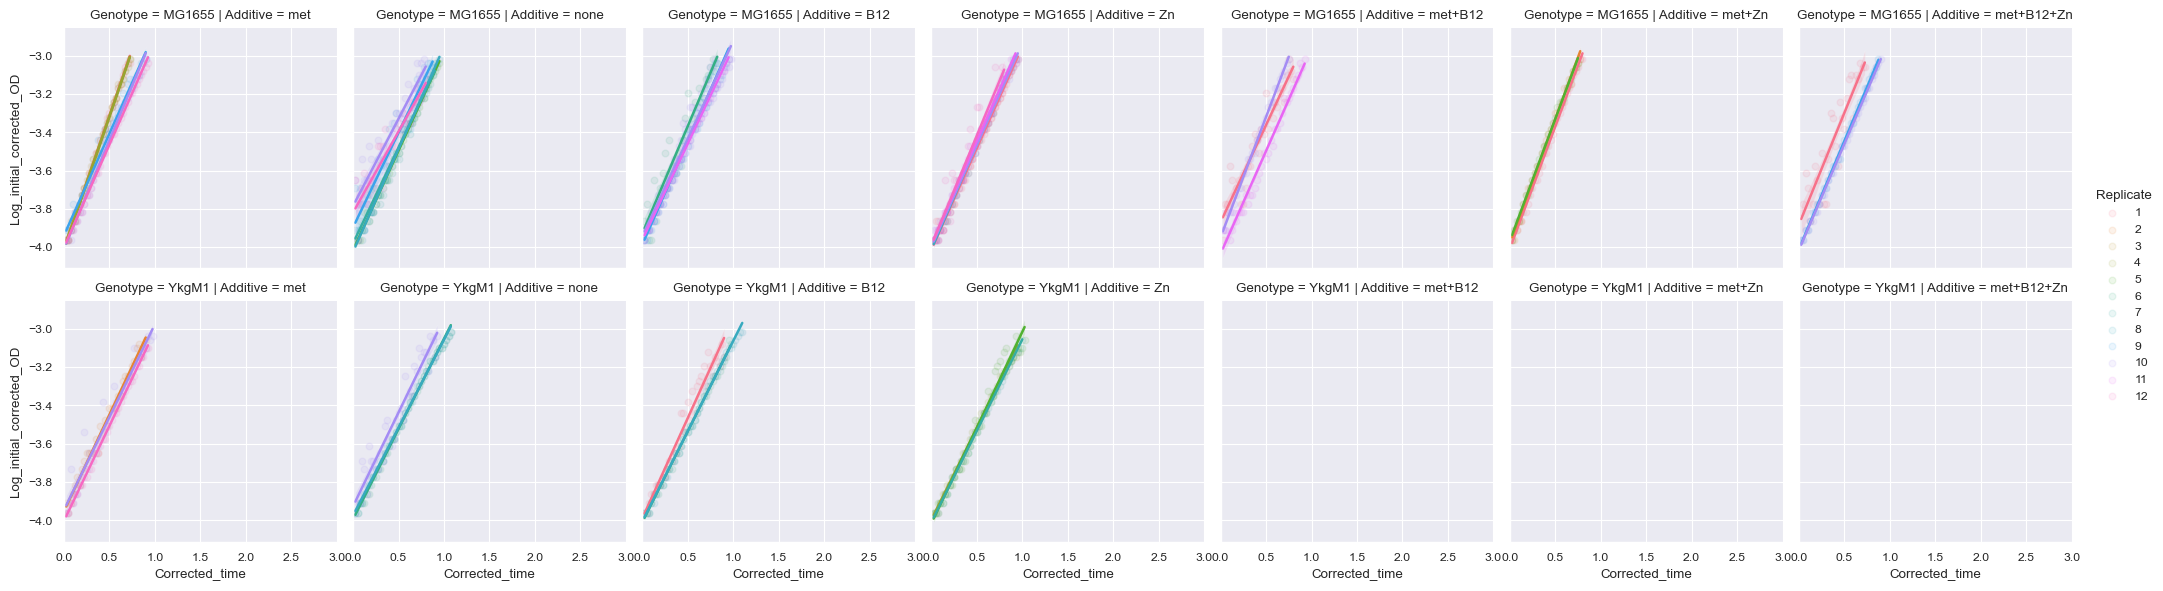

In [12]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", col="Additive", 
           # col_wrap=4,  \
           row="Genotype",
           height=3,
           data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0,3])


## Linear regression

Here, for each replicate, we fit a linear regression through the region we extracted earlier, depending on your choices of lower and upper bounds on log OD. Based on those independently estimated growth rates, we construct the bar + pointplot below. 

I think if you have less than 12 points per bar, you should just show the single points directly as well as the error bar. But that's just me. 

In [20]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"]
predicted_gr.head(10)

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_2231/2952087081.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])


Genotype Additive  Replicate    Plate     slope  intercept   slope_e  \
0   MG1655      B12          6  Plate 2  1.118861  -3.928502  0.061451   
1   MG1655      B12          9  Plate 1  1.020131  -3.979776  0.008795   
2   MG1655      B12          9  Plate 2  1.194681  -4.013303  0.015246   
3   MG1655      B12         10  Plate 1  0.985904  -3.971486  0.008702   
4   MG1655      B12         10  Plate 2  1.167625  -3.950184  0.019667   
5   MG1655      B12         11  Plate 1  1.004521  -3.962704  0.008080   
6   MG1655       Zn          1  Plate 1  1.040508  -4.001617  0.013269   
7   MG1655       Zn          1  Plate 2  1.085522  -4.025892  0.009434   
8   MG1655       Zn          8  Plate 2  1.096487  -4.011405  0.011048   
9   MG1655       Zn         10  Plate 1  1.062354  -3.997048  0.014318   

   intercept_e  doubling_time  
0     0.029934       0.619511  
1     0.004919       0.679469  
2     0.007427       0.580194  
3     0.004992       0.703058  
4     0.009296       0.593638  
5     0.004519       0.690027  
6     0.007421       0.666162  
7     0.005140       0.638538  
8     0.006020       0.632153  
9     0.008008       0.652464

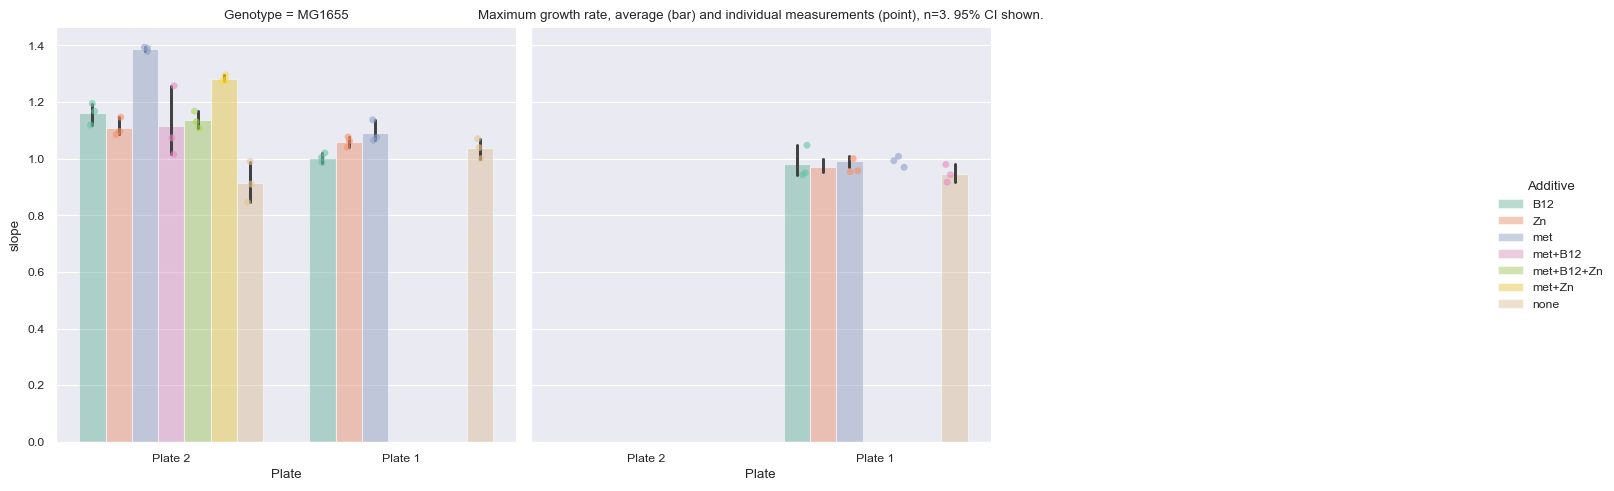

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    filter_df = pl.DataFrame(predicted_gr)
    filter_df.head(5)
    
    g = sns.catplot(x="Plate", y="slope", hue="Additive", 
                    data=filter_df.to_pandas(), kind="bar",  
                    height=5, aspect=1, alpha=0.5, errorbar="ci",
                    col="Genotype", col_wrap=3
                       );
    g.map_dataframe(sns.stripplot, x="Plate", y="slope", 
                    hue="Additive", palette="Set2",
                    alpha=0.6, dodge=True)
    
    plt.title("Maximum growth rate, average (bar) and individual measurements (point), n=3. 95% CI shown.")
    # plt.ylim([0.8, 1.4])
    
    plt.show()
    
   #  g.savefig("story1.png")

# Array based plates

In [18]:
gr_df = f_mdf.filter( (pl.col("Time") < 20))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -3.5).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -2.).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)

# regress and pick top x 
predicted_gr = gr_df \
.to_pandas().groupby(['Row', 'Column']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"] * 60


/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_2174/1518184285.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Row', 'Column']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()


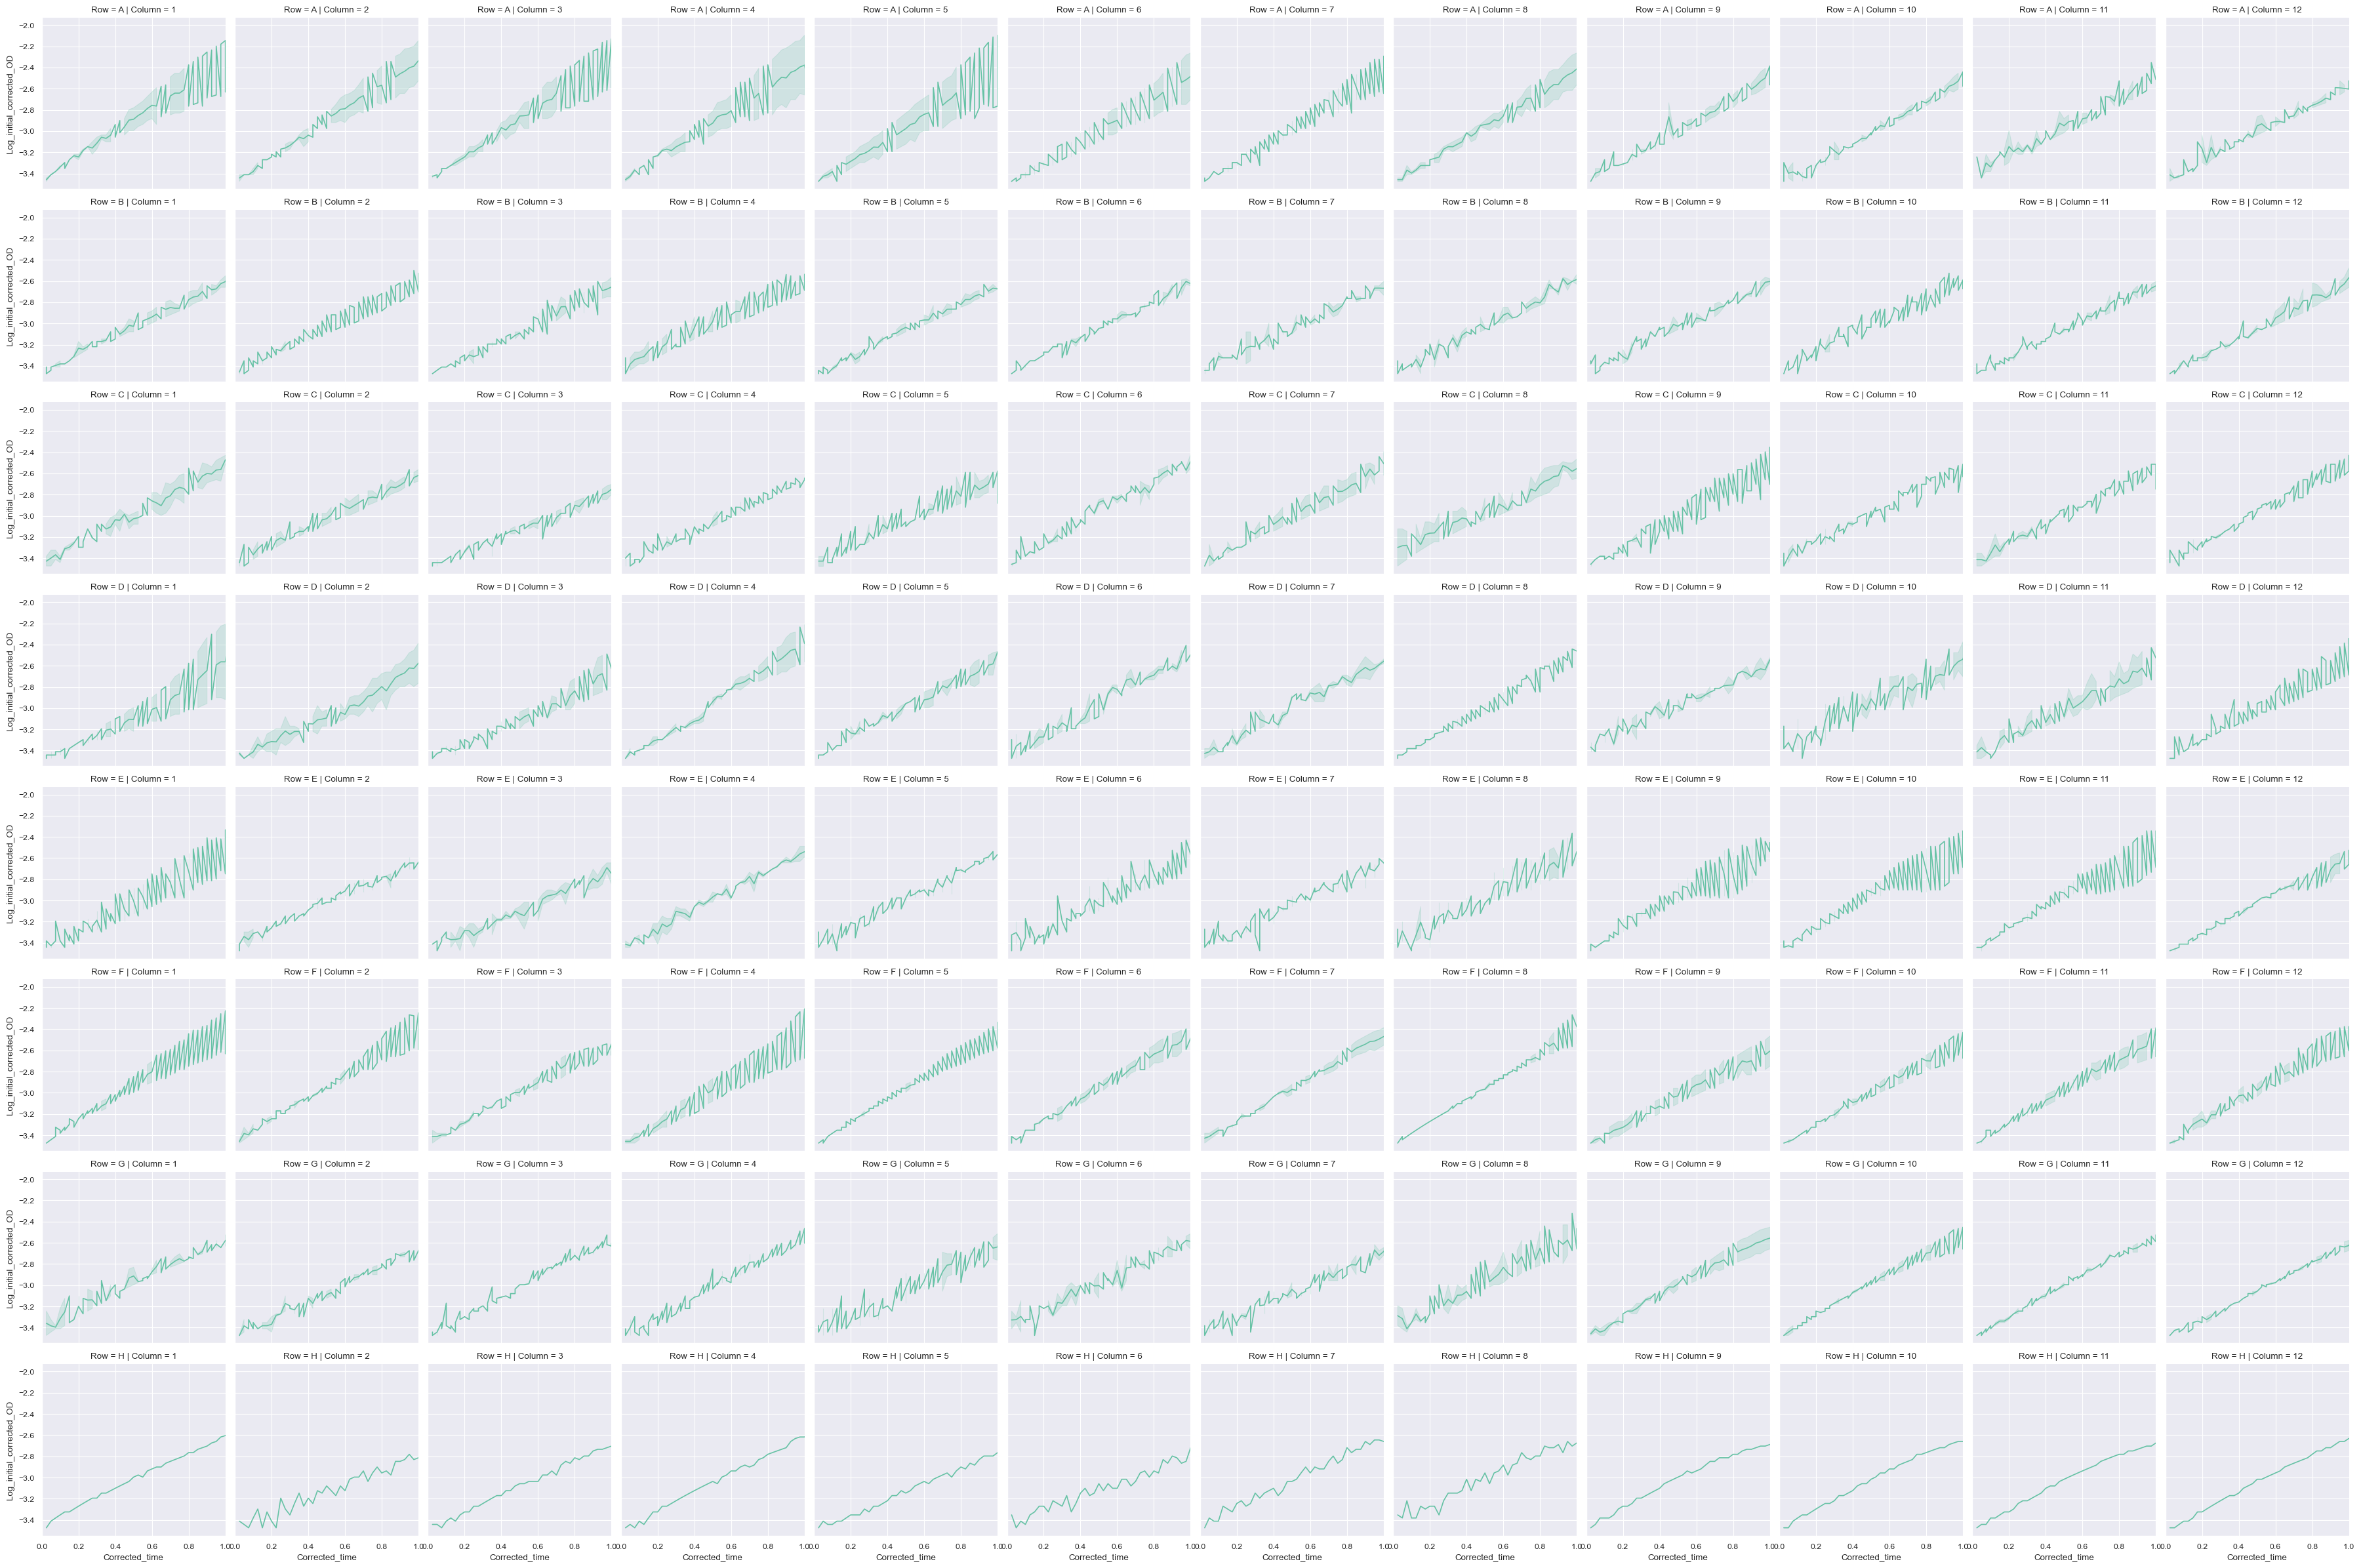

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_context("paper")
    sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD",  kind="line", row="Row", col="Column", 
                # row="Genotype",
                height=3, \
                data=gr_df)
    
    plt.xlim([0,1])

# plt.savefig("plates.png")

In [20]:
predicted_gr

Row Column     slope  intercept   slope_e  intercept_e  doubling_time
0    A      1  0.826438  -3.329768  0.033438     0.029106      50.322994
1    A     10  0.985103  -3.505350  0.010969     0.009622      42.217735
2    A     11  0.916358  -3.406970  0.017922     0.015151      45.384897
3    A     12  0.914166  -3.459927  0.012367     0.011299      45.493728
4    A      2  0.894228  -3.367389  0.031026     0.026315      46.508064
..  ..    ...       ...        ...       ...          ...            ...
91   H      5  0.681295  -3.478105  0.006410     0.007748      61.043797
92   H      6  0.660876  -3.444483  0.009172     0.010690      62.929870
93   H      7  0.749873  -3.409862  0.010440     0.010812      55.461178
94   H      8  0.676622  -3.361636  0.013662     0.014543      61.465374
95   H      9  0.917232  -3.480839  0.018303     0.018427      45.341649

[96 rows x 7 columns]

In [21]:
predicted_gr["log_dt"] = np.log(predicted_gr["doubling_time"])

pivot_df = pl.DataFrame(predicted_gr).pivot(index="Row", columns="Column", values="doubling_time")

pivot_df = pivot_df.select([str(i) for i in range(1,13)])
# pivot_df = pivot_df.select([str(i) for i in range(2,13)])

pivot_df

shape: (8, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ 1         ┆ 2         ┆ 3         ┆ 4         ┆ … ┆ 9         ┆ 10        ┆ 11        ┆ 12       │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 50.322994 ┆ 46.508064 ┆ 47.101658 ┆ 49.401449 ┆ … ┆ 41.992724 ┆ 42.217735 ┆ 45.384897 ┆ 45.49372 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ 46.541345 ┆ 47.737527 ┆ 53.500088 ┆ 48.761192 ┆ … ┆ 49.658205 ┆ 48.63818  ┆ 48.15247  ┆ 46.05052 │
│ 46.746445 ┆ 49.041486 ┆ 56.192121 ┆ 50.270566 ┆ … ┆ 48.892528 ┆ 50.454842 ┆ 50.46657  ┆ 45.54504 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ 72.733704 ┆ 58.081944 ┆ 60.983518 ┆ 42.097478 ┆ … ┆ 52.618112 ┆ 51.225306 ┆ 47.772092 ┆ 45.99378 │
│ 60.499806 ┆ 56.233988 ┆ 58.54285  ┆ 50.990011 ┆ … ┆ 50.747398 ┆ 48.515202 ┆ 49.572937 ┆ 45.33899 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ 44.693847 ┆ 47.89483  ┆ 52.402837 ┆ 47.794483 ┆ … ┆ 55.08875  ┆ 48.249796 ┆ 48.417059 ┆ 46.26355 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ 51.708616 ┆ 51.167347 ┆ 44.970165 ┆ 43.21783  ┆ … ┆ 49.306289 ┆ 49.658969 ┆ 46.834937 ┆ 48.62274 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ 46.681716 ┆ 58.923224 ┆ 51.793391 ┆ 44.524732 ┆ … ┆ 45.341649 ┆ 49.581116 ┆ 45.982569 ┆ 50.02724 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 1        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Axes: >

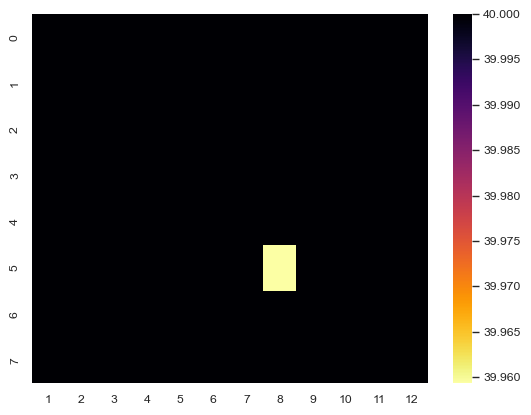

In [22]:
sns.heatmap(pivot_df.to_pandas(), cmap="inferno_r", vmax=40)